In [1]:
import os
import re
import torch
import pickle

import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from omegaconf import OmegaConf
from matplotlib.colors import LinearSegmentedColormap
from scipy.ndimage import zoom

from walrus_workshop.activation import ActivationsDataSet
from walrus_workshop.walrus import get_trajectory
from walrus_workshop.model import load_sae

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Using device: cuda


In [2]:
# Load configuration
cfg = OmegaConf.load(Path("configs") / "train.yaml")

# Load in the 
all_exemplars = pickle.load(open("exemplars/exemplars.pkl", "rb"))
print(type(all_exemplars))

# Activations dataset
datasets = ActivationsDataSet(
    name=cfg.walrus.dataset,
    layer_name=cfg.walrus.layer_name,
    split=cfg.training.split,
    seed=cfg.walrus.random_state,
    source_split=cfg.training.source_split,
    activations_base_path= Path(os.getcwd()) / "activations",
)
dataloader = datasets.to_dataloader(
    batch_size=cfg.training.batch_size, num_workers=cfg.training.num_workers
)

# Load the SAE model
cfg = OmegaConf.load(Path("configs") / "train.yaml")
# Load the trained SAE
checkpoint_path = (
    Path("checkpoints")
    / "sae_checkpoint_blocks.20.space_mixing.activation_source_test_k_active=32_k_aux=2048_latent=22528_beta=0.1.pt"
)
# "this_dir", "checkpoints", "sae_checkpoint_blocks.20.space_mixing.activation_source_test.pt"
# )
sae_model, sae_config = load_sae(checkpoint_path)
sae_model = sae_model.to(device).eval()


<class 'dict'>


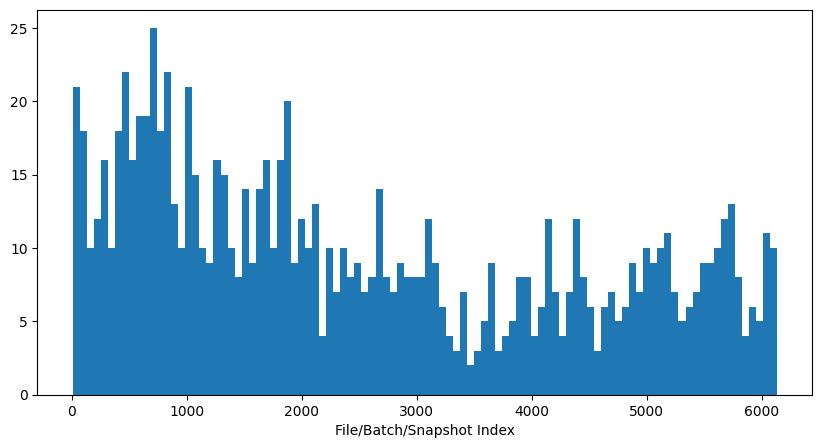

In [3]:
# Check the distribution of file indices, these correspond to the position in the snapshot so should run from 0 to 6*32*32 = 6144
file_indices = []
for _, exemplars in all_exemplars.items():
    file_indices.extend(exemplars['file_indices'])
plt.figure(figsize=(10, 5))
plt.hist(file_indices, bins=100)
plt.xlabel("File/Batch/Snapshot Index")
plt.show()


In [4]:
def search_filename(file_name, key) -> int:
    traj_match = re.search(fr"{key}_([+-]?\d+(?:e[+-]?\d+)?)", file_name, re.IGNORECASE)
    if traj_match:
        traj_number = int(traj_match.group(1))
        return traj_number
    else:
        raise ValueError(f"No number found in file name for {key}.")

# Exemplars for the first feature
feature_index_in_all_exemplars = 0
exemplars = all_exemplars[list(all_exemplars.keys())[feature_index_in_all_exemplars]]
print(exemplars)
file_index = exemplars['file_indices'][0]
file_path = Path(exemplars['file_paths'][0])
file_name = file_path.stem
print(f"File name: {file_name}")

traj_number = search_filename(file_name, "traj")
step_number = search_filename(file_name, "step")
print(f"Trajectory number: {traj_number}, Step number: {step_number}")

trajectory, trajectory_metadata = get_trajectory(cfg.walrus.dataset, traj_number)


{'activations': array([0.45568866, 0.45534137, 0.45513716, 0.4551263 , 0.4549966 ,
       0.45492455, 0.45490327, 0.45485866, 0.4547431 , 0.45469972,
       0.4546897 , 0.45468923, 0.4546722 , 0.4546014 , 0.4546011 ,
       0.45459256, 0.45457044, 0.4545114 , 0.45447937, 0.4544271 ],
      dtype=float32), 'file_indices': array([2725, 2757, 2268, 1276, 2693, 1308, 2300, 2789, 2565, 2661, 2220,
       2597, 2076, 2332, 2108, 1244, 1116, 2140, 4208, 1052]), 'file_paths': array(['/home/krosenfeld/projects/walrus-workshop/experiments/well/activations/test/blocks.20.space_mixing.activation/shear_flow/step_0009_traj_94_Reynolds_5e+05_Schmidt_1e+01_layerblocks.20.space_mixing.activation.zarr',
       '/home/krosenfeld/projects/walrus-workshop/experiments/well/activations/test/blocks.20.space_mixing.activation/shear_flow/step_0009_traj_94_Reynolds_5e+05_Schmidt_1e+01_layerblocks.20.space_mixing.activation.zarr',
       '/home/krosenfeld/projects/walrus-workshop/experiments/well/activations/test

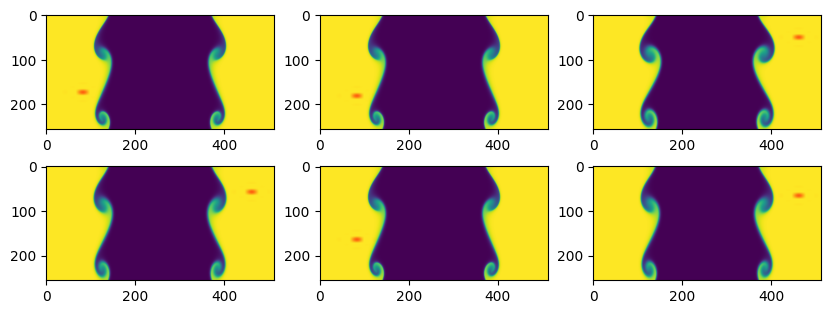

In [11]:
mask_colors = [(1, 0, 0, 0), (1, 0, 0, 0.6)]  # transparent to semi-transparent red
mask_cmap = LinearSegmentedColormap.from_list('mask', mask_colors)

field_index = 0 # 0: tracer

fig, axs = plt.subplots(2, 3, figsize=(10, 2 * 1.8))
for i in range(6):
    ax = axs[i//3, i%3]

    # parse exemplar info
    file_name = Path(exemplars['file_paths'][i]).stem
    step_number = search_filename(file_name, "step")
    traj_number = search_filename(file_name, "traj")
    feature_location = np.unravel_index(exemplars['file_indices'][i], (cfg.walrus.n_steps_input, 32, 32))

    # load trajectory
    trajectory, trajectory_metadata = get_trajectory(cfg.walrus.dataset, traj_number)

    # 
    ax.imshow(trajectory['input_fields'][0, feature_location[0] + step_number, :, :, 0, field_index].numpy())

    # parse feature info
    feature_map = np.zeros((32,32))
    feature_map[feature_location[1], feature_location[2]] = 1.0
    im2 = ax.imshow(zoom(feature_map, (8, 16)), cmap=mask_cmap, vmin=0, vmax=1)

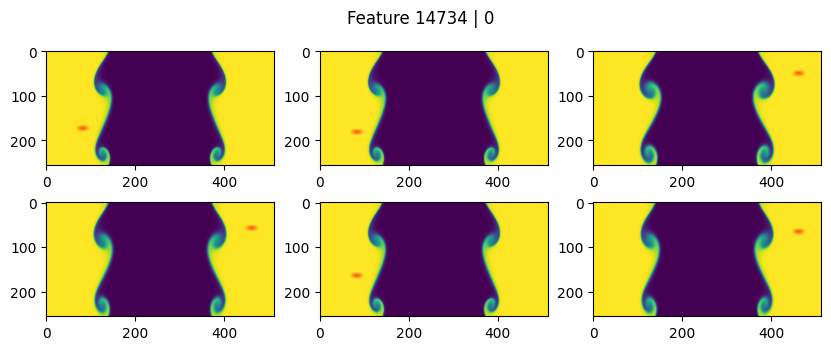

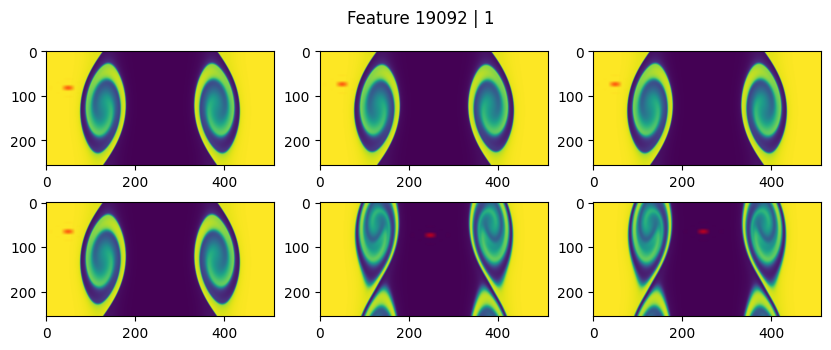

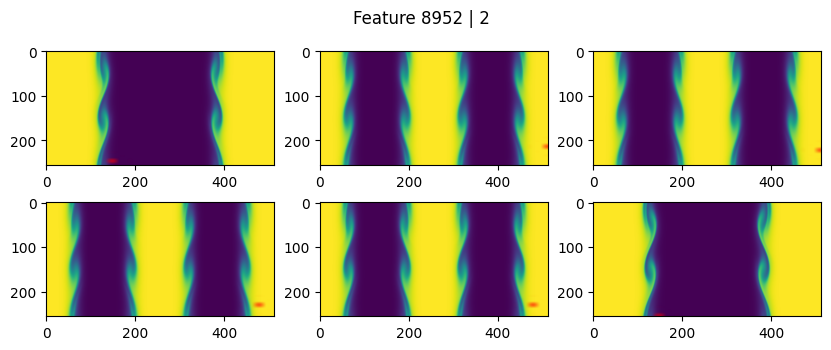

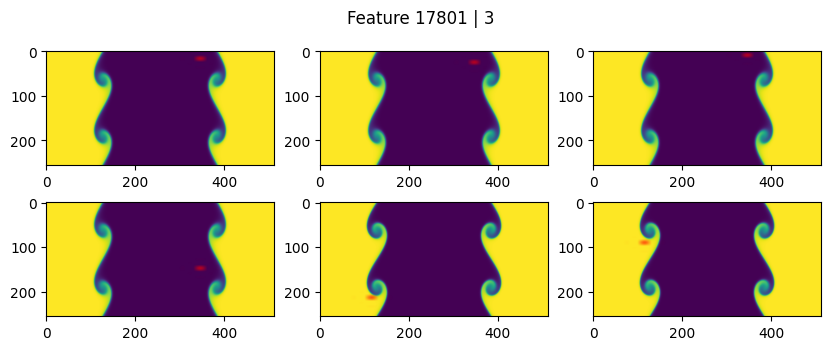

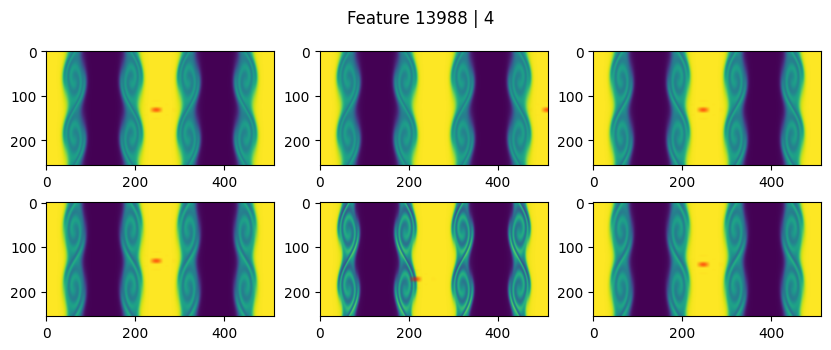

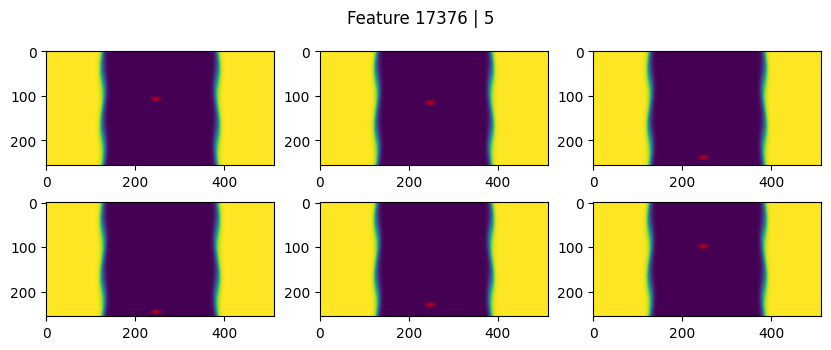

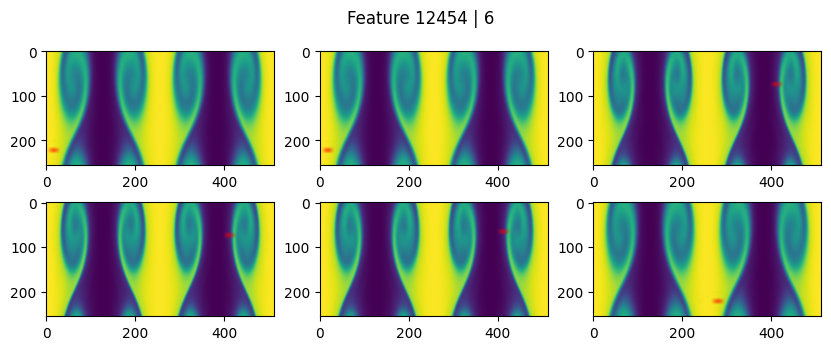

In [12]:
for cnt, (feature_key, exemplars) in enumerate(all_exemplars.items()):
    field_index = 0 # 0: tracer

    fig, axs = plt.subplots(2, 3, figsize=(10, 2 * 1.8))
    for i in range(6):
        ax = axs[i//3, i%3]

        # parse exemplar info
        file_name = Path(exemplars['file_paths'][i]).stem
        step_number = search_filename(file_name, "step")
        traj_number = search_filename(file_name, "traj")
        feature_location = np.unravel_index(exemplars['file_indices'][i], (cfg.walrus.n_steps_input, 32, 32))

        # load trajectory
        trajectory, trajectory_metadata = get_trajectory(cfg.walrus.dataset, traj_number)

        ax.imshow(trajectory['input_fields'][0, feature_location[0] + step_number, :, :, 0, field_index].numpy())

        # parse feature info
        feature_map = np.zeros((32,32))
        feature_map[feature_location[1], feature_location[2]] = 1.0
        im2 = ax.imshow(zoom(feature_map, (8, 16)), cmap=mask_cmap, vmin=0, vmax=1)

    plt.suptitle(f"Feature {feature_key} | {cnt}")

    if cnt > 5:
        break

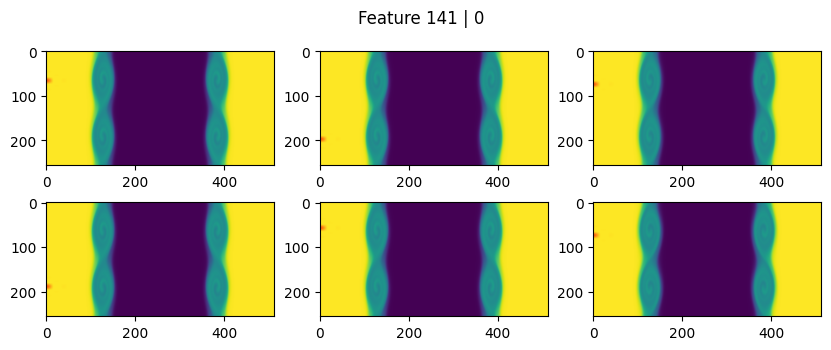

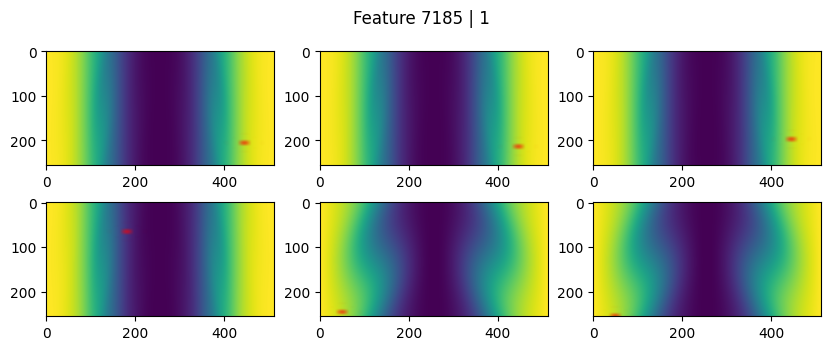

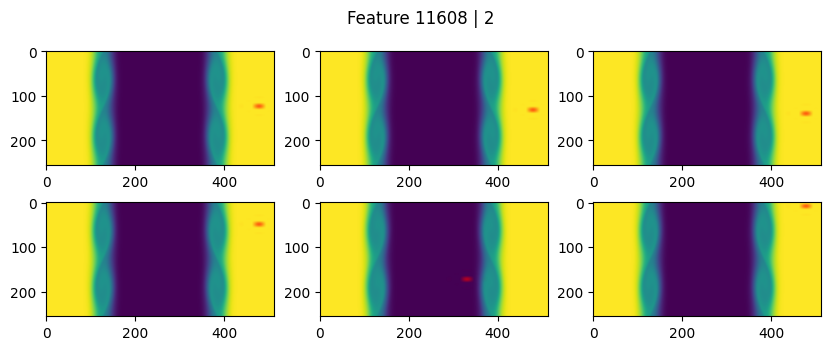

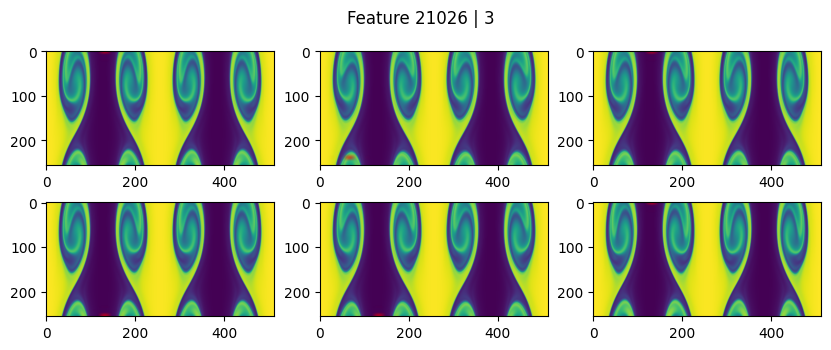

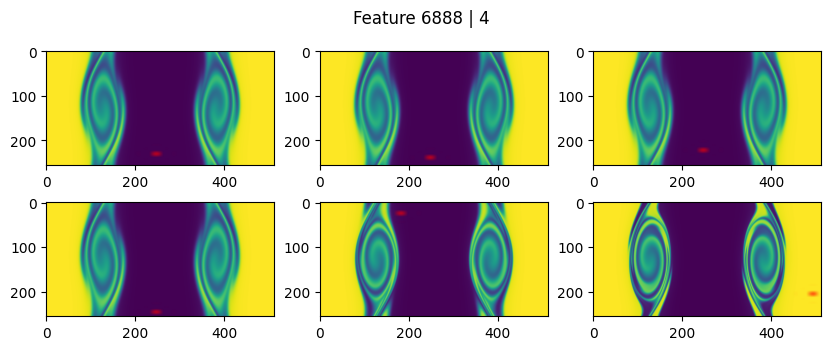

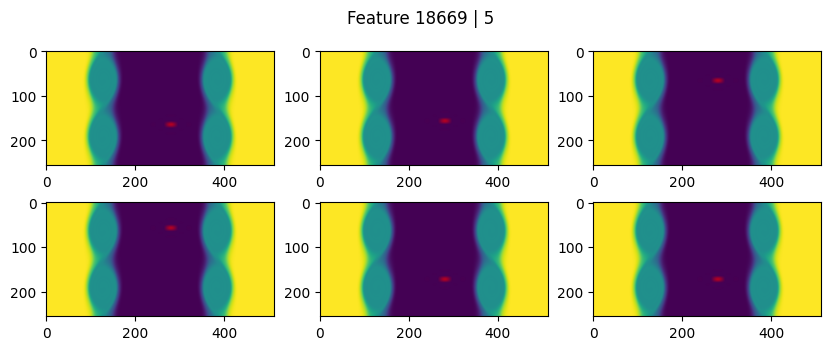

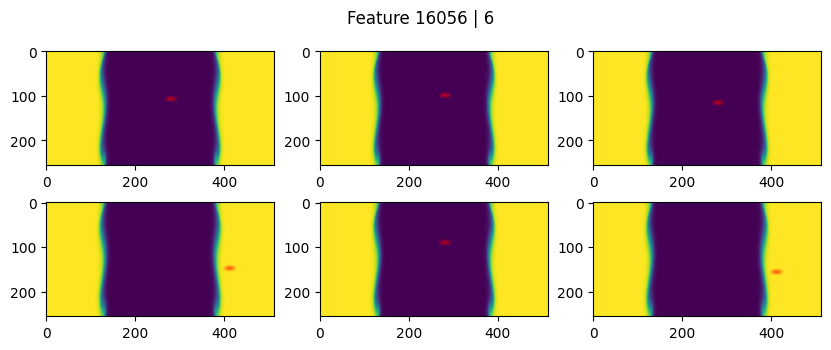

ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/home/krosenfeld/projects/walrus-workshop/.venv/lib/python3.12/site-packages/zmq/eventloop/zmqstream.py", line 565, in _log_error
    f.result()
  File "/home/krosenfeld/projects/walrus-workshop/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 341, in dispatch_control
    await self.process_control(msg)
  File "/home/krosenfeld/projects/walrus-workshop/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 347, in process_control
    idents, msg = self.session.feed_identities(msg, copy=False)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/krosenfeld/projects/walrus-workshop/.venv/lib/python3.12/site-packages/jupyter_client/session.py", line 993, in feed_identities
    raise ValueError(msg)
ValueError: DELIM not in msg_list
ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  Fi

In [13]:
all_exemplar_keys = list(all_exemplars.keys())
rev_all_exemplar_keys = all_exemplar_keys[::-1]
for cnt, (feature_key) in enumerate(rev_all_exemplar_keys):
    exemplars = all_exemplars[feature_key]
    field_index = 0 # 0: tracer

    fig, axs = plt.subplots(2, 3, figsize=(10, 2 * 1.8))
    for i in range(6):
        ax = axs[i//3, i%3]

        # parse exemplar info
        file_name = Path(exemplars['file_paths'][i]).stem
        step_number = search_filename(file_name, "step")
        traj_number = search_filename(file_name, "traj")
        feature_location = np.unravel_index(exemplars['file_indices'][i], (cfg.walrus.n_steps_input, 32, 32))

        # load trajectory
        trajectory, trajectory_metadata = get_trajectory(cfg.walrus.dataset, traj_number)

        ax.imshow(trajectory['input_fields'][0, feature_location[0] + step_number, :, :, 0, field_index].numpy())

        # parse feature info
        feature_map = np.zeros((32,32))
        feature_map[feature_location[1], feature_location[2]] = 1.0
        im2 = ax.imshow(zoom(feature_map, (8, 16)), cmap=mask_cmap, vmin=0, vmax=1)

    plt.suptitle(f"Feature {feature_key} | {cnt}")

    if cnt > 5:
        break